<a href="https://colab.research.google.com/github/Anju982/data-science-portfolio/blob/main/Credit_Scoring_%26_Risk_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title Credit Scoring & Risk Assessment (Portfolio Project)
Author: Anjana Urulugastenna
This notebook builds an XGBoost classifier to predict credit default risk.
It includes feature engineering, performance evaluation (ROC/AUC), and SHAP explainability.

SETUP

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve)

# Set visual style to Dark Mode (High Contrast)
plt.style.use('dark_background')
sns.set_palette("bright")

DATA LOADING

In [2]:
print("⬇️ Downloading Dataset from Kaggle...")
# Download dataset
path = kagglehub.dataset_download("laotse/credit-risk-dataset")

# Robustly find the CSV file (handles versioning differences)
csv_files = glob.glob(os.path.join(path, "*.csv"))
if csv_files:
    full_path = csv_files[0]
    print(f"✅ Data loaded from: {full_path}")
else:
    raise FileNotFoundError("No CSV file found in the downloaded path.")

df = pd.read_csv(full_path)

⬇️ Downloading Dataset from Kaggle...
Using Colab cache for faster access to the 'credit-risk-dataset' dataset.
✅ Data loaded from: /kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


PREPROCESSING & FEATURE ENGINEERING

In [3]:
# 1. Handling Missing Values (For a resume, we can be more strategic, but dropping is fine for a demo)
print(f"Original shape: {df.shape}")
df = df.dropna()
print(f"Shape after dropping nulls: {df.shape}")

# 2. Feature Engineering (Financial Ratios)
# Loan to Income is standard. Let's add 'Loan to Employment Length' if applicable,
# but for now, we will stick to your solid base ratio.
df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']

# 3. Encoding
# Using LabelEncoder for simplicity with XGBoost (Tree models handle this well)
le_dict = {} # Keep track of encoders to inverse_transform later if needed
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# 4. Loan to emploayment Length
df['loan_to_employment_length_ratio'] = df['loan_amnt'] / df['person_emp_length']



for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

Original shape: (32581, 12)
Shape after dropping nulls: (28638, 12)


MODEL TRAINING

In [4]:
print("\n⚙️ Training XGBoost Model...")

X = df.drop(columns=['loan_status'])
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# FIX: Replace infinite values with NaN before training
# This is crucial because divisions by zero can create inf values,
# and XGBoost expects NaNs for missing values by default, not inf.
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Initialize XGBoost
# enable_categorical=True is a modern feature, but since we encoded, it's standard.
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)
print("✅ Model Trained Successfully")


⚙️ Training XGBoost Model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:51:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model Trained Successfully


EVALUATION & VISUALIZATION


--- Classification Report (Retrained Model) ---
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6731
           1       0.97      0.70      0.82      1861

    accuracy                           0.93      8592
   macro avg       0.95      0.85      0.89      8592
weighted avg       0.94      0.93      0.93      8592

Accuracy (Retrained Model): 0.9321
ROC AUC Score (Retrained Model): 0.9390


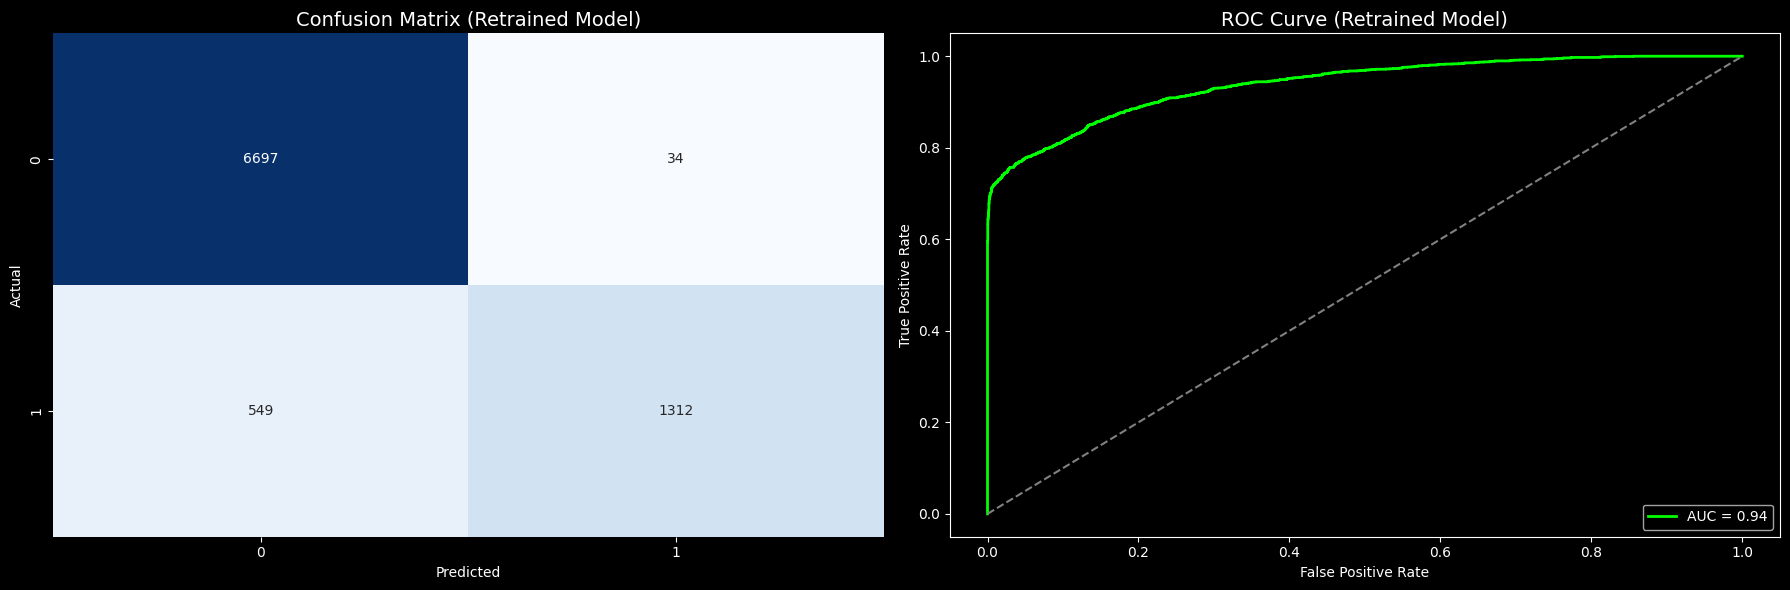

In [5]:
y_pred_new = model.predict(X_test)
y_pred_proba_new = model.predict_proba(X_test)[:, 1]

# 1. Text Metrics for Retrained Model
print("\n--- Classification Report (Retrained Model) ---")
print(classification_report(y_test, y_pred_new))
print(f"Accuracy (Retrained Model): {accuracy_score(y_test, y_pred_new):.4f}")
print(f"ROC AUC Score (Retrained Model): {roc_auc_score(y_test, y_pred_proba_new):.4f}")

# 2. Visualization Canvas for Retrained Model
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Confusion Matrix
cm_new = confusion_matrix(y_test, y_pred_new)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix (Retrained Model)', fontsize=14, color='white')
axes[0].set_xlabel('Predicted', color='white')
axes[0].set_ylabel('Actual', color='white')

# ROC Curve
fpr_new, tpr_new, _ = roc_curve(y_test, y_pred_proba_new)
axes[1].plot(fpr_new, tpr_new, color='#00ff00', lw=2, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_new):.2f}')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_title('ROC Curve (Retrained Model)', fontsize=14, color='white')
axes[1].set_xlabel('False Positive Rate', color='white')
axes[1].set_ylabel('True Positive Rate', color='white')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

SHAP EXPLAINABILITY


🔍 Generating SHAP Explanations...


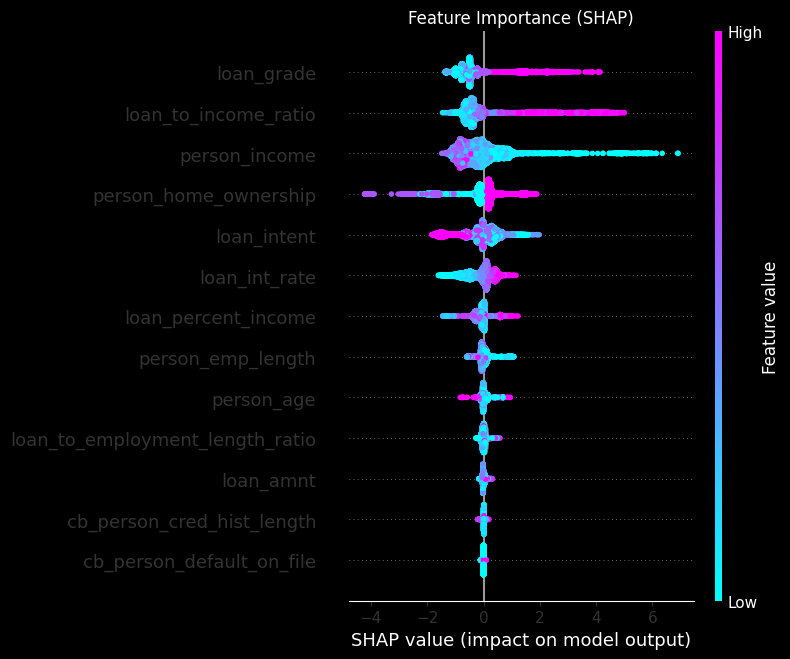

In [6]:
print("\n🔍 Generating SHAP Explanations...")

# Using TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot Summary
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (SHAP)", color='white')
# Note: For binary classification, shap_values might be a list. We take the index 1 (Positive class/Default) if so.
if isinstance(shap_values, list):
    shap_vals_to_plot = shap_values[1]
else:
    shap_vals_to_plot = shap_values

shap.summary_plot(shap_vals_to_plot, X_test, show=False, cmap='cool')
plt.gcf().set_facecolor('black') # Force dark background for SHAP figure
plt.show()

<Figure size 1000x600 with 0 Axes>

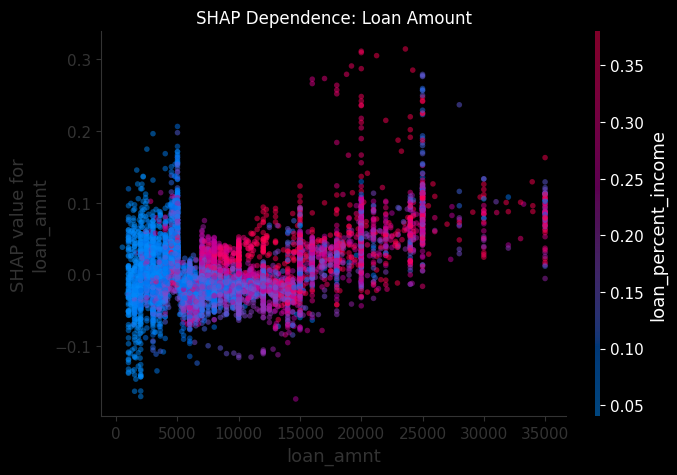

In [7]:
# Dependence Plot for Loan Amount
plt.figure(figsize=(10, 6))
shap.dependence_plot("loan_amnt", shap_vals_to_plot, X_test, show=False, alpha=0.5)
plt.title("SHAP Dependence: Loan Amount", color='white')
plt.show()